<a href="https://colab.research.google.com/github/MicheleGiambelli/PlotTwisters-Project/blob/main/Progetto%20data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import dash
from dash import dcc, html
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS

Caricare i dataset salvati nel pc

In [ ]:
from google.colab import files

# Carica i file
uploaded = files.upload()

# Mostra i nomi dei file caricati
for filename in uploaded.keys():
    print(f'File {filename} caricato con successo!')

Saving file5.txt to file5 (1).txt
Saving file6.txt to file6 (1).txt
File file5 (1).txt caricato con successo!
File file6 (1).txt caricato con successo!


Consideriamo ora solo il primo data set (file5). Successivamente vorrei poter integrare i dataset in un unico file.

In [ ]:
df = pd.read_csv(list(uploaded.keys())[0], header=None, delimiter='\t', names=['token', 'ner_tag'])


# Info sul dataframe
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32520 entries, 0 to 32519
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   token    32520 non-null  object
 1   ner_tag  32520 non-null  object
dtypes: object(2)
memory usage: 508.2+ KB
None


In [ ]:
print(df.describe())
print(df.head())

        token ner_tag
count   32520   32520
unique   9539       7
top         .       O
freq      957   26321
        token ner_tag
0    Millions       O
1          of       O
2  family-run       O
3      #farms       O
4        hold       O


In [ ]:
# Controllo dei valori nulli
print("Valori nulli per colonna:")
print(df.isnull().sum())

Valori nulli per colonna:
token      0
ner_tag    0
dtype: int64


Quindi non ci sono valori nulli.

L'annotazione utilizata nel dataframe  è parte di un sistema di etichettatura comunemente utilizzato per il Named Entity Recognition (NER). Queste etichette vengono assegnate ai token (parole o frasi) in un testo per identificare a quale tipo di entità appartengono. Ecco una spiegazione dettagliata di ciascun prefisso:

Tipi di Etichettatura NER
B-PER (Begin - Person):

Utilizzato per segnare l'inizio di un'entità di tipo "persona". Indica che la parola successiva è il primo token di un nome di persona.
Esempio: In "Mario Rossi", "Mario" sarebbe etichettato come B-PER.


I-PER (Inside - Person):

Utilizzato per segnare i token all'interno di un'entità di tipo "persona". Se ci sono più parole in un nome di persona, tutte le parole tranne la prima riceveranno questa etichetta.
Esempio: In "Mario Rossi", "Rossi" sarebbe etichettato come I-PER.


B-ORG (Begin - Organization):

Indica l'inizio di un'entità di tipo "organizzazione". Utilizzato per segnalare nomi di aziende, istituzioni, enti e così via.
Esempio: In "Università di Milano", "Università" sarebbe B-ORG.


I-ORG (Inside - Organization):

Utilizzato per i token all'interno di un'entità di tipo "organizzazione".
Esempio: In "Università di Milano", "di" e "Milano" sarebbero I-ORG e I-ORG rispettivamente.


B-LOC (Begin - Location):

Segna l'inizio di un'entità di tipo "luogo". Usato per identificare nomi di città, paesi, regioni e altri punti di riferimento geografici.
Esempio: In "Roma", "Roma" sarebbe etichettato come B-LOC.


I-LOC (Inside - Location):

Utilizzato per token all'interno di un'entità di tipo "luogo".
Esempio: In "Città del Vaticano", "Città" sarebbe B-LOC e "del Vaticano" potrebbe essere etichettato come I-LOC a seconda dell'approccio di annotazione.


O (Outside):

Indica che il token non appartiene a nessuna entità. Quindi, tutte le parole che non sono parte di nomi di persone, organizzazioni o luoghi vengono etichettate come O.
Esempio: In "Mario vive a Roma", "vive" sarebbe etichettato come O.

In [ ]:
# Detect empty string

blanks = []
for index,label,review in df.itertuples():
    if type(review)==str:
        if review.isspace():
            blanks.append(index)

blanks

[]

Non ci sono stringhe vuote.

Creiamo adesso i labels sulla base dei NER esistenti.

Breve spiegazione dei lables:

LOC (Location):Indica luoghi geografici.
Esempio: "Roma".

PER (Person):Rappresenta nomi di persone.
Esempio: "Mario Rossi".

ORG (Organization):Rappresenta nomi di organizzazioni o aziende.
Esempio: "Google".

MISC (Miscellaneous):Entità varie che non rientrano nelle categorie precedenti (eventi, opere d'arte, ecc.).
Esempio: "Festival di Cannes"

In [ ]:
########################
# CREAZIONE DEI LABLES
########################

# Mappatura dei tag NER a categorie
mapping = {
    'B-LOC': 'LOC',
    'I-LOC': 'LOC',
    'B-PER': 'PER',
    'I-PER': 'PER',
    'B-ORG': 'ORG',
    'I-ORG': 'ORG',
    'O': 'O',  # Per token non etichettati
    'B-MISC': 'MISC',
    'I-MISC': 'MISC'
}

# Creiamo una nuova colonna "Label" basata sulla mappatura
df['Label'] = df['ner_tag'].map(mapping)

# Verifica la nuova colonna
print(df.head(50))

                      token ner_tag Label
0                  Millions       O     O
1                        of       O     O
2                family-run       O     O
3                    #farms       O     O
4                      hold       O     O
5                       the       O     O
6                       key       O     O
7                        to       O     O
8                    global       O     O
9                   #hunger       O     O
10                  reveals       O     O
11                      #UN   B-ORG   ORG
12                   report       O     O
13                        .       O     O
14   http://t.co/9JKaxcMKJ0       O     O
15                   Cousin       O     O
16                       of       O     O
17                    Reeva   B-PER   PER
18                Steenkamp   I-PER   PER
19                     says       O     O
20               #Pistorius   B-PER   PER
21                   should       O     O
22                      pay       

Successivamente effettuiamo i seguenti passaggi:

1. Dizionari di Etichette: Creare due dizionari per mappare le etichette (tags) a indici numerici e viceversa. Questo è utile per la codifica delle etichette quando si addestra un modello, poiché i modelli spesso richiedono input numerici.

2. Creazione di Frasi: Raggruppare i token in frasi basandosi su segni di punteggiatura che indicano la fine di una frase. Questo è importante per analizzare il contesto in cui le entità vengono menzionate.

3. Filtraggio dei Token: Creare un dataset che esclude i token di punteggiatura e altri token non rilevanti. Questo pulisce i dati e si concentra solo sui token significativi per l'analisi delle entità.

In [ ]:
labels_to_indices = {label: idx for idx, label in enumerate(df['ner_tag'].unique())}
indices_to_labels = {idx: label for idx, label in enumerate(df['ner_tag'].unique())}

# Stampa i dizionari
print("Labels to Indices:", labels_to_indices)
print("Indices to Labels:", indices_to_labels)

# Raggruppare i token in frasi
df['Sentence_Num'] = 0
sentence_counter = 1

for i in range(len(df)):
    if df['token'][i] in ['.', '!', '?']:  # Considera i segni di punteggiatura
        sentence_counter += 1
    df.at[i, 'Sentence_Num'] = f'Sentence {sentence_counter}'

# Creazione di un dataset filtrato
punctuation_marks = {'.', ',', ';', ':', '?', '!'}
tokens_to_remove = ['-DOCSTART-']  # Aggiungi qui eventuali token da rimuovere

# Filtraggio dei dati
df['Is_Significant'] = ~((df['token'].isin(punctuation_marks)) | (df['token'].isin(tokens_to_remove)))
filtered_data = df[df['Is_Significant']].copy()  # Crea un nuovo dataframe

# Rimuovi la colonna di filtraggio
filtered_data.drop(columns=['Is_Significant'], inplace=True)

# Stampa il nuovo dataframe
print(filtered_data.head(30))

Labels to Indices: {'O': 0, 'B-ORG': 1, 'B-PER': 2, 'I-PER': 3, 'B-LOC': 4, 'I-ORG': 5, 'I-LOC': 6}
Indices to Labels: {0: 'O', 1: 'B-ORG', 2: 'B-PER', 3: 'I-PER', 4: 'B-LOC', 5: 'I-ORG', 6: 'I-LOC'}


<ipython-input-35-1e92a635f7d1>:15: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Sentence 1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



                     token ner_tag Label Sentence_Num
0                 Millions       O     O   Sentence 1
1                       of       O     O   Sentence 1
2               family-run       O     O   Sentence 1
3                   #farms       O     O   Sentence 1
4                     hold       O     O   Sentence 1
5                      the       O     O   Sentence 1
6                      key       O     O   Sentence 1
7                       to       O     O   Sentence 1
8                   global       O     O   Sentence 1
9                  #hunger       O     O   Sentence 1
10                 reveals       O     O   Sentence 1
11                     #UN   B-ORG   ORG   Sentence 1
12                  report       O     O   Sentence 1
14  http://t.co/9JKaxcMKJ0       O     O   Sentence 2
15                  Cousin       O     O   Sentence 2
16                      of       O     O   Sentence 2
17                   Reeva   B-PER   PER   Sentence 2
18               Steenkamp  

# 1. Exploratory analysis

**Bar chart visualization for sentences**:

In [ ]:

# Definizione dei colori per le etichette
tag_colors = {
    'O': 'rgb(0, 255, 0)',          # Outside
    'I-PER': 'rgb(255, 0, 0)',      # Person
    'I-MISC': 'rgb(255, 165, 0)',   # Miscellaneous
    'I-LOC': 'rgb(128, 0, 128)',    # Location
    'I-ORG': 'rgb(0, 128, 0)'       # Organization
}

# Creazione della Dash app
app = dash.Dash(__name__)

# Creazione del layout
app.layout = html.Div([
    html.H1("Visualizzazione dei Tag dei Token"),

    dcc.Dropdown(
        id='sentence-dropdown',
        options=[{'label': sentence, 'value': sentence} for sentence in df['Sentence_Num'].unique()],
        value=df['Sentence_Num'].unique()[0],  # Seleziona la prima frase di default
        multi=False,
    ),

    dcc.Graph(id='bar-chart')
])

# Callback per aggiornare il grafico
@app.callback(
    dash.dependencies.Output('bar-chart', 'figure'),
    [dash.dependencies.Input('sentence-dropdown', 'value')]
)
def update_bar_chart(selected_sentence):
    # Filtrare il DataFrame per la frase selezionata
    filtered_df = df[df['Sentence_Num'] == selected_sentence]

    # Conteggio delle entità per la frase selezionata
    entity_counts = filtered_df['ner_tag'].value_counts().reset_index()
    entity_counts.columns = ['ner_tag', 'count']

    # Creazione del bar chart
    fig = px.bar(entity_counts, x='ner_tag', y='count', color='ner_tag',
                 color_discrete_map=tag_colors,
                 labels={'ner_tag': 'Entità', 'count': 'Conteggio'},
                 title=f'Conteggio delle Entità per: {selected_sentence}')

    return fig

# Esecuzione dell'app
if __name__ == '__main__':
    app.run_server(debug=True)




<IPython.core.display.Javascript object>

Word Cloud: per vedere quali parole sono le più frequenti escludendo le stop words, che sono parole comuni che non portano significato utile (come "e", "il", "di", ecc.).

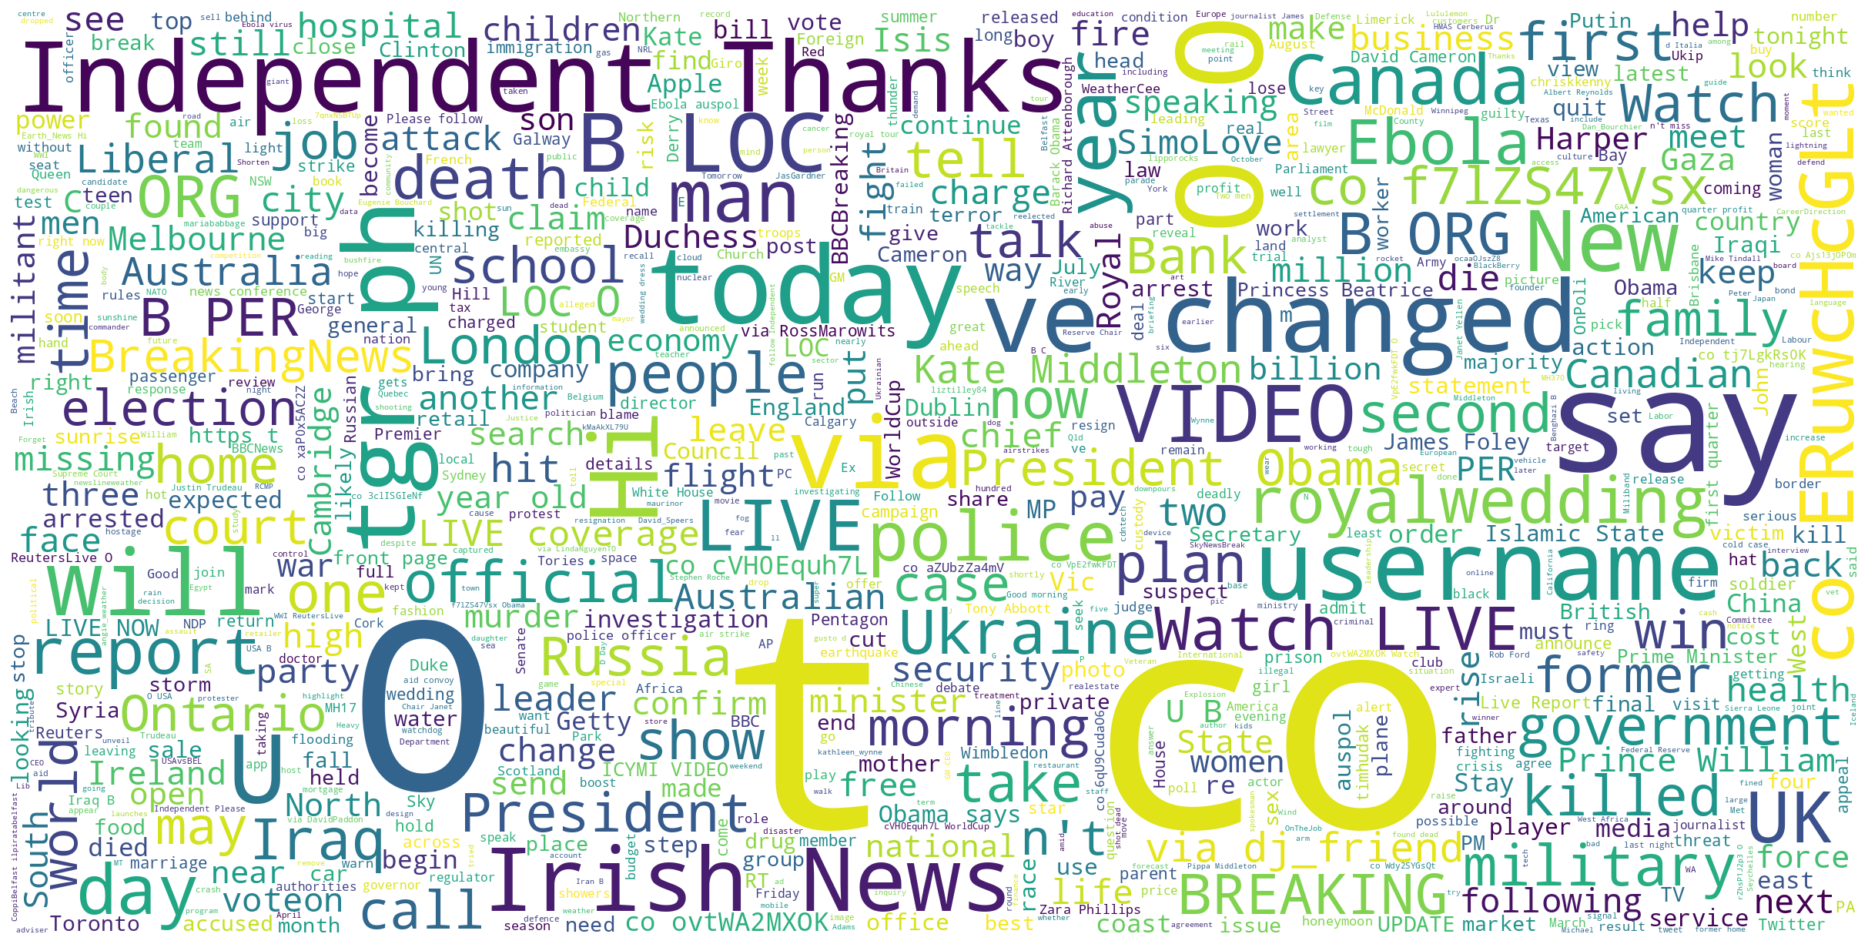

In [ ]:
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Costruisci la stringa del testo (sostituisci con il tuo DataFrame)
punt = {'.', ',', ';', ':', '?', '!'}
text = " ".join(df['token'])  # Assicurati di avere abbastanza parole qui

# Stopwords personalizzate
stopwords = set(STOPWORDS)
stopwords.add('DOCSTART')
stopwords.add('S')

# Crea la Word Cloud senza maschera per testare
wiki_wc = WordCloud(
    background_color='white',  # Sfondo bianco
    width=2400,                # Larghezza dell'immagine
    height=1200,               # Altezza dell'immagine
    max_words=6000,            # Numero massimo di parole
    max_font_size=400,         # Dimensione massima delle parole
    min_font_size=10,          # Dimensione minima delle parole
    stopwords=stopwords,
    contour_color='black',     # Colore del contorno
    contour_width=2            # Larghezza del contorno
)

# Genera la Word Cloud
try:
    wiki_wc.generate(text)
except ValueError as e:
    print(f"Errore nella generazione della Word Cloud: {e}")


# Visualizza l'immagine della Word Cloud
plt.figure(figsize=(24, 12))  # Dimensione della figura
plt.imshow(wiki_wc, interpolation='bilinear')
plt.axis('off')  # Nasconde gli assi
plt.show()




Saving Immagine 2024-10-22 150130.png to Immagine 2024-10-22 150130 (4).png


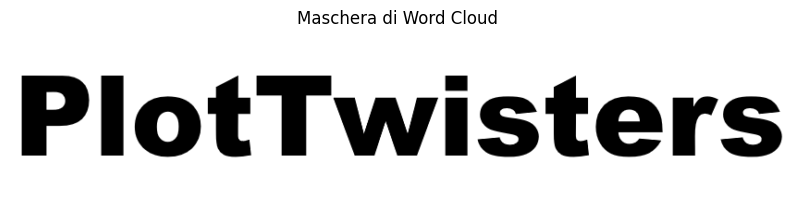

Numero di parole nel testo: 35414


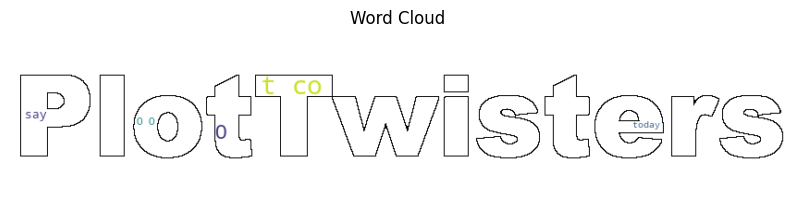

In [ ]:

import numpy as np
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files

# Passo 1: Caricare l'immagine
uploaded = files.upload()

# Assumiamo che il file caricato sia la maschera
mask_image_path = next(iter(uploaded))  # Ottieni il nome del file caricato

# Passo 2: Aprire l'immagine come maschera
mask_image = Image.open(mask_image_path)

# Assicurati che l'immagine sia in modalità L (grayscale)
mask_image = mask_image.convert("L")

# Converte la maschera in un array numpy
mask_array = np.array(mask_image)

# Visualizza la maschera per controllare
plt.figure(figsize=(10, 10))
plt.imshow(mask_array, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis('off')
plt.title('Maschera di Word Cloud')
plt.show()

# Costruisci la stringa del testo (sostituisci con il tuo DataFrame)
punt = {'.', ',', ';', ':', '?', '!'}
text = " ".join(df['token'])  # Assicurati di avere abbastanza parole qui
print("Numero di parole nel testo:", len(text.split()))  # Controlla quante parole ci sono

# Stopwords personalizzate
stopwords = set(STOPWORDS)
stopwords.add('DOCSTART')
stopwords.add('S')

# Passo 3: Crea la Word Cloud utilizzando la maschera
wiki_wc = WordCloud(
    background_color='white',  # Sfondo bianco
    max_words=2000,            # Numero massimo di parole
    max_font_size=300,         # Dimensione massima delle parole
    min_font_size=10,          # Dimensione minima delle parole
    stopwords=stopwords,
    mask=mask_array,           # Usa la maschera
    contour_color='black',     # Colore del contorno
    contour_width=1            # Larghezza del contorno
)

# Genera la Word Cloud
try:
    wiki_wc.generate(text)
except ValueError as e:
    print(f"Errore nella generazione della Word Cloud: {e}")

# Passo 4: Visualizza l'immagine della Word Cloud
plt.figure(figsize=(10, 10))  # Dimensione della figura
plt.imshow(wiki_wc, interpolation='bilinear')
plt.axis('off')  # Nasconde gli assi
plt.title('Word Cloud')
plt.show()





Box Plot per la lunghezza dei tweets:

<ipython-input-28-5282b7fdd0eb>:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




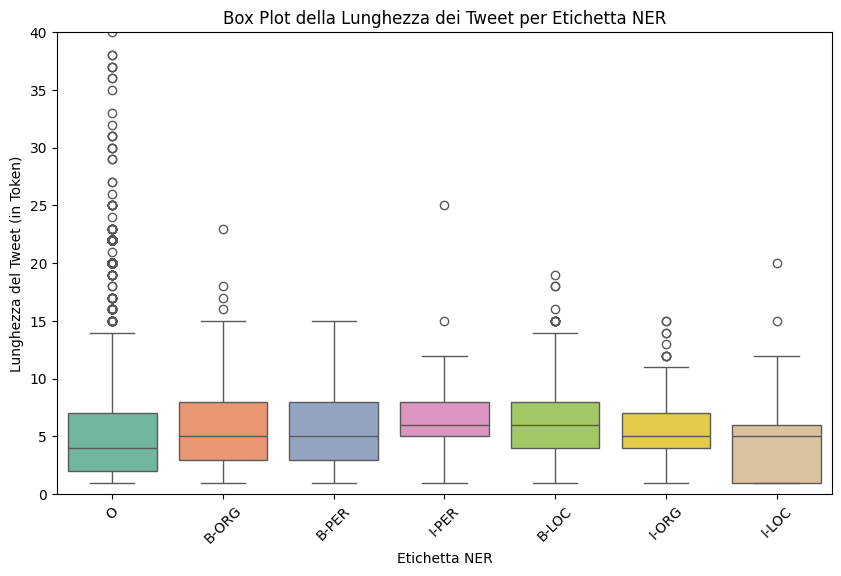

In [ ]:
# Calcola la lunghezza dei token
df['tweet_length'] = df['token'].apply(len)

# Crea il box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='ner_tag', y='tweet_length', palette='Set2')
plt.title("Box Plot della Lunghezza dei Tweet per Etichetta NER")
plt.xlabel("Etichetta NER")
plt.ylabel("Lunghezza del Tweet (in Token)")

# Imposta i limiti dell'asse y
plt.ylim(0, 40)

plt.xticks(rotation=45)
plt.show()



